In [30]:
import torch
import cv2
from torchvision import transforms
from utils.loss_function import SaliencyLoss
from utils.loss_function import *
from utils.data_process import preprocess_img, postprocess_img
import numpy as np

print("All imports successful")

All imports successful


In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from TranSalNet_Res import TranSalNet
model = TranSalNet()
model.load_state_dict(torch.load(r'pretrained_models/TranSalNet_Res.pth', map_location=torch.device('cpu')))

model = model.to(device) 
model.eval()

print("Model imported successfully")

Model imported successfully


torch.Size([1, 1, 288, 384])


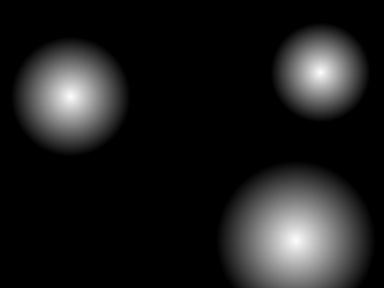

In [32]:
#TARGET CIRCLES
target = torch.zeros(1, 1, 288, 384)

cx1, cy1 = target.shape[2] / 1.2, target.shape[3] / 1.3
cx2, cy2 = target.shape[2] /3, target.shape[2] /4.1 
cx3, cy3 = target.shape[2] /4, target.shape[2] /0.9

max_dist1, max_dist2, max_dist3 = 80, 60, 50  # set max distances for both circles

xx, yy = torch.meshgrid(torch.linspace(0, target.shape[2] - 1, target.shape[2]), torch.linspace(0, target.shape[3] - 1, target.shape[3]))
distances1 = torch.sqrt((xx - cx1) ** 2 + (yy - cy1) ** 2)
distances2 = torch.sqrt((xx - cx2) ** 2 + (yy - cy2) ** 2)
distances3 = torch.sqrt((xx - cx3) ** 2 + (yy - cy3) ** 2)

values = torch.clamp(1 - distances1 / max_dist1, 0) + torch.clamp(1 - distances2 / max_dist2, 0) + torch.clamp(1 - distances3 / max_dist3, 0)  # add the two circle values together

target[0, 0, :, :] = values
print(target.shape)

toPIL = transforms.ToPILImage()
pic = toPIL(target.squeeze())
display(pic)


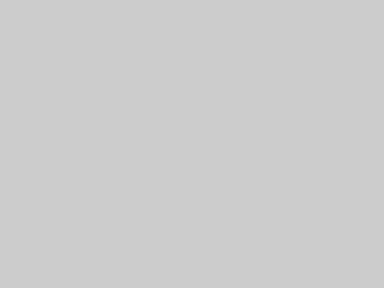

In [63]:
#TARGET CORNER
target = torch.ones(1, 1, 288, 384)

target = torch.sub(target,0.2)

# Set the top right of the tensor to white
# target[:, :, :target.shape[2]//3, target.shape[3]//2:] = 1.0

toPIL = transforms.ToPILImage()
pic = toPIL(target.squeeze())
display(pic)

torch.Size([1, 1, 288, 384])


/Users/hasinmahmood/opt/miniconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


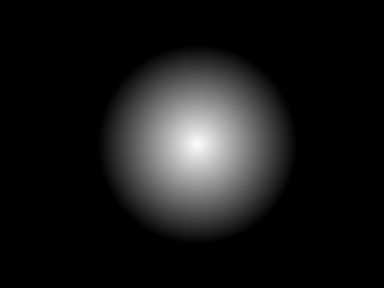

In [3]:
#TARGET CIRCLES
target = torch.zeros(1, 1, 288, 384)

cx1, cy1 = 144, 197

max_dist1 = 100  # set max distances for both circles

xx, yy = torch.meshgrid(torch.linspace(0, target.shape[2] - 1, target.shape[2]), torch.linspace(0, target.shape[3] - 1, target.shape[3]))
distances1 = torch.sqrt((xx - cx1) ** 2 + (yy - cy1) ** 2)

values = torch.clamp(1 - distances1 / max_dist1, 0)

target[0, 0, :, :] = values
print(target.shape)

toPIL = transforms.ToPILImage()
pic = toPIL(target.squeeze())
display(pic)

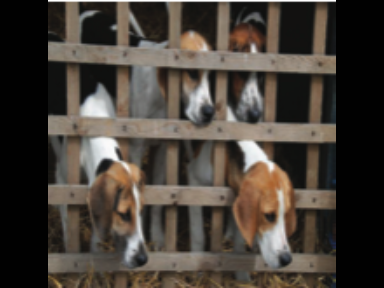

In [33]:
test_img = r'./example/8.png'

#padding and resizing input image into 384x288
original_image = preprocess_img(test_img)
#normalising values
original_image = np.array(original_image)/255.
original_image = np.expand_dims(np.transpose(original_image,(2,0,1)),axis=0)
original_image = torch.from_numpy(original_image)
original_image = original_image.type(torch.FloatTensor).to(device)

display(toPIL(original_image.squeeze()))

------------------------------------------
tensor(1.6845)
tensor([3.0119], grad_fn=<MeanBackward1>)
20
------------------------------------------
tensor(1.0312)
tensor([1.9114], grad_fn=<MeanBackward1>)
19.0
------------------------------------------
tensor(0.1528)
tensor([0.7034], grad_fn=<MeanBackward1>)
18.05
------------------------------------------
tensor(0.0701)
tensor([0.2298], grad_fn=<MeanBackward1>)
17.1475


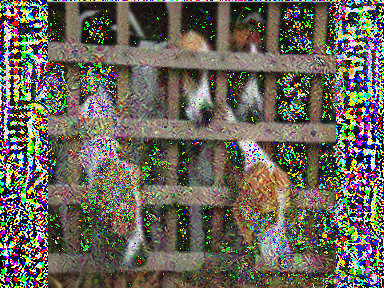

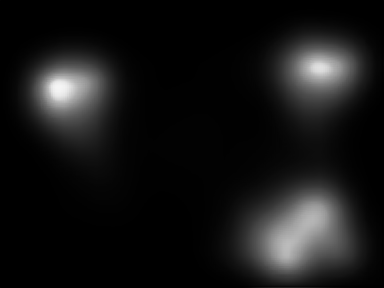

4


In [36]:
def patch_attack(patch, target_saliency,loss_target, lr):
    loss_fn=SaliencyLoss()
    loss, iterations =10, 0
    while loss_target < loss:

        print('------------------------------------------')
        
        patch = patch.clone().detach().requires_grad_(True)
        patch.retain_grad()

        out = model(patch)
        
        loss = loss_fn(out,target_saliency,loss_type='kldiv')
        # loss = loss_fn(out,target,loss_type='cc')
        loss.backward()
        print(torch.max(patch.grad)*lr)
        patch = patch - (patch.grad * lr)
        
        print(loss)
        print(lr)

        if lr > 1:
            lr = lr * 0.95


        iterations = iterations + 1
        
    return patch, iterations
        
        
    
final_patch, iterations = patch_attack(original_image,target,loss_target = 0.5, lr = 20)

display(toPIL(final_patch.squeeze()))

final_patch_saliency = model(final_patch)
display(toPIL(final_patch_saliency.squeeze()))

print(iterations)


In [79]:
out = model(original_image)

torch.Size([1, 1, 288, 384])


<class 'PIL.Image.Image'>


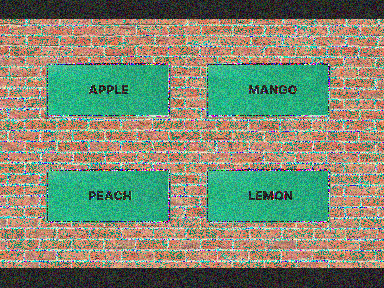

In [79]:
noisy_original_image = original_image + ((0.1**0.5)*torch.rand(1,3,288,384))
pic = toPIL(noisy_original_image.squeeze())
print(type(pic))
display(pic)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 3999.5, 2599.5, -0.5)

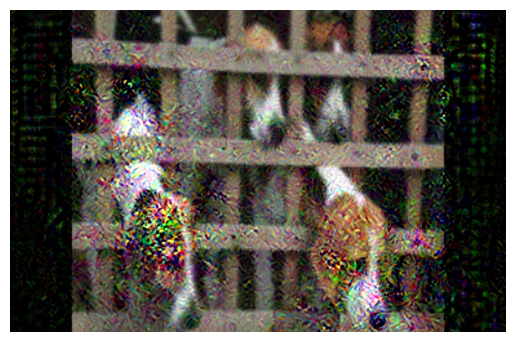

In [37]:
import matplotlib.pyplot as plt

a = postprocess_img(final_patch.squeeze().detach().permute(1,2,0), './example/5.jpg')
plt.imshow(a)
plt.axis("off")

In [54]:
import matplotlib.image
a = np.clip(a, 0, 1)
matplotlib.pyplot.imsave('out.png', a)

In [38]:
def patch_attack(patch, target_saliency,loss_target, lr):
    loss_fn=SaliencyLoss()
    loss, iterations =0, 0
    while loss_target > loss:

        print('------------------------------------------')
        
        patch = patch.clone().detach().requires_grad_(True)
        patch.retain_grad()

        out = model(patch)
        print(out.shape)
        print(target.shape)
        # loss = loss_fn(out,target_saliency,loss_type='kldiv')
        loss = loss_fn(out,target,loss_type='cc')
        loss.backward()
        print(torch.max(patch.grad)*lr)
        patch = patch + (patch.grad * lr)
        
        print(loss)
        print(lr)

        if lr > 1:
            lr = lr * 0.65
            if lr < 1:
                lr = 1


        iterations = iterations + 1
        
    return patch, iterations
        
print(original_image.shape)        
    
final_patch, iterations = patch_attack(original_image,target,loss_target = 0.987, lr = 25)

# display(toPIL(final_patch.squeeze()))

# final_patch_saliency = model(final_patch)
# display(toPIL(final_patch_saliency.squeeze()))

# print(iterations)


torch.Size([1, 3, 288, 384])


In [5]:
import matplotlib.pyplot as plt

a = postprocess_img(final_patch.squeeze().detach().permute(1,2,0), './example/2.jpg')
plt.imshow(a)
plt.axis("off")

NameError: name 'final_patch' is not defined

(2600, 4000)
(2600, 4000, 3)


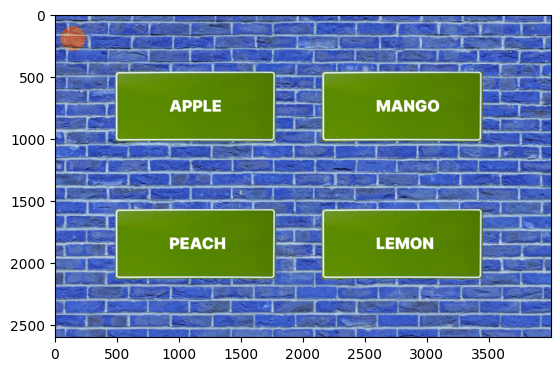

In [29]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


img = cv.imread('./example/5.jpg')
plt.imshow(img)

blank = np.zeros(img.shape[:2], dtype='uint8')

center_coordinates = (cx1, cy1)

radius = max_dist1

mask = cv.circle(blank, center_coordinates, radius, 255, -1)

masked = cv.bitwise_and(img, img, mask=mask)
print(mask.shape)
print(img.shape)
masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
img = cv2.bitwise_and(img, img, mask=cv2.bitwise_not(mask))
img = cv2.addWeighted(masked, 1, img, 1, 0)

plt.imshow(img)

